<a href="https://colab.research.google.com/github/srinivasiyengar/NewCastle-University-Internship/blob/main/Comparison_noisy_unet_and_unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Importing required packages
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import os
import gc
import pickle

from tqdm import tqdm_notebook as tqdm

import pandas as pd
import numpy as np
import math
from numpy import asarray
import cv2
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn import metrics

from collections import Counter
from collections import defaultdict
from sklearn.model_selection import train_test_split

%tensorflow_version 1.x  # Use Tensorflow version 1.x
import tensorflow as tf
from keras import backend as K
from keras import Model
from keras.layers import UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose,Dropout
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate,add

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback

import keras
from keras.optimizers import Adam
from keras.losses import binary_crossentropy

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.x  # Use Tensorflow version 1.x`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/masks.csv')

data.head(1)

Unnamed: 0 flags  ...  shape_type  version
0           0    {}  ...     polygon    4.1.2

[1 rows x 12 columns]

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train test split/train/train.csv')['imagePath'].drop_duplicates().to_frame()
noisy = pd.read_csv('/content/drive/MyDrive/train test split/train/noisy.csv')['imagePath'].drop_duplicates().to_frame()
test = pd.read_csv('/content/drive/MyDrive/train test split/test/test.csv')['imagePath'].drop_duplicates().to_frame()

print(train.shape, noisy.shape, test.shape)
train.head(2)

(391, 1) (391, 1) (100, 1)


imagePath
0   TN_628553_13.48331743_80.02359483_18.json
46    TN_631458_12.4979227_79.6948508_18.json

In [ ]:
noisy.head(1)

imagePath
0  TN_628553_13.48331743_80.02359483_18_noisy.json

In [ ]:
class Train_DataGenerator(keras.utils.Sequence):
    def __init__(self, df=train, batch_size = 4,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/train test split/train/satellite/'
        self.mask_path = '/content/drive/MyDrive/train test split/train/masks/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #fliping the images horizontally and normalization of samples
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,512,1024,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,512,1024,9),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['imagePath'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f.split(".json")[0] + ".png").convert('RGB').resize((1024,512))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
                #run-length encoding on the pixel values
            pixel = [(90, 17, 229), # Class 0 (road_kaccha)
                     (136, 47, 136), # Class 1 (road_kaccha)
                     (219, 86, 20), # Class 2 (Water Body)
                     (15, 0, 179), # Class 3 (Green Farm)
                     (255, 201, 0), # Class 4 (Vegetation)
                     (70, 90, 110), # Class 5 (Barren Land)
                     (230, 163, 163), # Class 6 (Others)
                     (255, 0, 0), # Class 7 (Building)
                     (255, 115, 0), # Class 8 (Dry Farm)
                     ]
            img = Image.open(self.mask_path + f.split(".json")[0] + ".png").convert('RGB').resize((1024,512))
            img = np.array(img)
            for j,k in enumerate(pixel):
                mask = np.array(((img==k).astype(int))[:,:,0] & ((img==k).astype(int))[:,:,1] & ((img==k).astype(int))[:,:,2])
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

In [ ]:
class Train_DataGenerator_noisy(keras.utils.Sequence):
    def __init__(self, df=noisy, batch_size = 4,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/train test split/train/noisy/'
        self.mask_path = '/content/drive/MyDrive/train test split/train/masks/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #fliping the images horizontally and normalization of samples
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,512,1024,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,512,1024,9),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['imagePath'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f.split("_noisy.json")[0] + "_noisy.png").convert('RGB').resize((1024,512))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
                #run-length encoding on the pixel values
            pixel = [(90, 17, 229), # Class 0 (road_kaccha)
                     (136, 47, 136), # Class 1 (road_kaccha)
                     (219, 86, 20), # Class 2 (Water Body)
                     (15, 0, 179), # Class 3 (Green Farm)
                     (255, 201, 0), # Class 4 (Vegetation)
                     (70, 90, 110), # Class 5 (Barren Land)
                     (230, 163, 163), # Class 6 (Others)
                     (255, 0, 0), # Class 7 (Building)
                     (255, 115, 0), # Class 8 (Dry Farm)
                     ]
            img = Image.open(self.mask_path + f.split("_noisy.json")[0] + ".png").convert('RGB').resize((1024,512))
            img = np.array(img)
            for j,k in enumerate(pixel):
                mask = np.array(((img==k).astype(int))[:,:,0] & ((img==k).astype(int))[:,:,1] & ((img==k).astype(int))[:,:,2])
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

In [ ]:
class Val_DataGenerator(keras.utils.Sequence):
    def __init__(self, df=test, batch_size = 4,shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.data_path = '/content/drive/MyDrive/train test split/test/satellite/'
        self.mask_path = '/content/drive/MyDrive/train test split/test/satellite/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    #fliping the images horizontally and normalization of samples
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':False, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,512,1024,3),dtype=np.float32) #images
        y = np.empty((self.batch_size,512,1024,9),dtype=np.int8)    #masks
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['imagePath'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f.split(".json")[0] + ".png").convert('RGB').resize((1024,512))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
                #run-length encoding on the pixel values
            pixel = [(90, 17, 229), # Class 0 (road_kaccha)
                     (136, 47, 136), # Class 1 (road_kaccha)
                     (219, 86, 20), # Class 2 (Water Body)
                     (15, 0, 179), # Class 3 (Green Farm)
                     (255, 201, 0), # Class 4 (Vegetation)
                     (70, 90, 110), # Class 5 (Barren Land)
                     (230, 163, 163), # Class 6 (Others)
                     (255, 0, 0), # Class 7 (Building)
                     (255, 115, 0), # Class 8 (Dry Farm)
                     ]
            img = Image.open(self.mask_path + f.split(".json")[0] + ".png").convert('RGB').resize((1024,512))
            img = np.array(img)
            for j,k in enumerate(pixel):
                mask = np.array(((img==k).astype(int))[:,:,0] & ((img==k).astype(int))[:,:,1] & ((img==k).astype(int))[:,:,2])
                y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        return X, y

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    '''returns a block of two 3x3 convolutions, each  followed by a rectified linear unit (ReLU)'''
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [ ]:
def get_unet(input_img, n_filters, dropout, batchnorm):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = UpSampling2D()(c5)
    u6 = Conv2D(filters = n_filters *8, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u6)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = UpSampling2D()(c6)
    u7 = Conv2D(filters = n_filters *4, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u7)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = UpSampling2D()(c7)
    u8 = Conv2D(filters = n_filters *2, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u8)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = UpSampling2D()(c8)
    u9 = Conv2D(filters = n_filters *1, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u9)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(9, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
def IOU_performance_metric (img1,img2): 
    intersection = np.logical_and((img1), (img2))
    union = np.logical_or((img1), (img2))
    iou_score = tf.sum(intersection) / tf.sum(union)
    iou_score

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def bce_dice_loss(y_true, y_predict):
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

def  dice_loss(y_true, y_predict):
    return (1-dice_coef(y_true, y_predict))

In [ ]:
input_img = Input((512, 1024, 3), name='img')

model = get_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])
# model.summary()

model_noisy = get_unet(input_img, n_filters=8, dropout=0.2, batchnorm=True)
model_noisy.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=[tf.keras.metrics.MeanIoU(num_classes=9)])
# model_noisy.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
train_batches = Train_DataGenerator(shuffle=True)
valid_batches = Val_DataGenerator()
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 12, verbose=1,)


Epoch 1/12
97/97 [==============================] - 300s 3s/step - loss: 1.3621 - mean_io_u: 0.4485 - val_loss: 2.0340 - val_mean_io_u: 0.4542
Epoch 2/12
97/97 [==============================] - 271s 3s/step - loss: 1.1820 - mean_io_u: 0.4559 - val_loss: 1.4836 - val_mean_io_u: 0.4567
Epoch 3/12
97/97 [==============================] - 272s 3s/step - loss: 1.0617 - mean_io_u: 0.4572 - val_loss: 1.4108 - val_mean_io_u: 0.4575
Epoch 4/12
97/97 [==============================] - 272s 3s/step - loss: 0.9620 - mean_io_u: 0.4577 - val_loss: 1.3823 - val_mean_io_u: 0.4579
Epoch 5/12
97/97 [==============================] - 273s 3s/step - loss: 0.8960 - mean_io_u: 0.4581 - val_loss: 1.2246 - val_mean_io_u: 0.4582
Epoch 6/12
97/97 [==============================] - 273s 3s/step - loss: 0.8358 - mean_io_u: 0.4582 - val_loss: 1.2378 - val_mean_io_u: 0.4583
Epoch 7/12
97/97 [==============================] - 274s 3s/step - loss: 0.7922 - mean_io_u: 0.4584 - val_loss: 1.2364 - val_mean_io_u: 0.458

In [ ]:
train_batches = Train_DataGenerator_noisy(shuffle=True)
valid_batches = Val_DataGenerator()
history_nosiy = model_noisy.fit_generator(train_batches, validation_data = valid_batches, epochs = 12, verbose=1,)

Epoch 1/12
97/97 [==============================] - 360s 4s/step - loss: 1.4400 - mean_io_u_1: 0.4486 - val_loss: 10.1431 - val_mean_io_u_1: 0.4466
Epoch 2/12
97/97 [==============================] - 317s 3s/step - loss: 1.2746 - mean_io_u_1: 0.4459 - val_loss: 1.4995 - val_mean_io_u_1: 0.4495
Epoch 3/12
97/97 [==============================] - 307s 3s/step - loss: 1.1531 - mean_io_u_1: 0.4515 - val_loss: 1.3918 - val_mean_io_u_1: 0.4528
Epoch 4/12
97/97 [==============================] - 304s 3s/step - loss: 1.0432 - mean_io_u_1: 0.4537 - val_loss: 1.3588 - val_mean_io_u_1: 0.4544
Epoch 5/12
97/97 [==============================] - 309s 3s/step - loss: 0.9491 - mean_io_u_1: 0.4549 - val_loss: 1.3280 - val_mean_io_u_1: 0.4554
Epoch 6/12
97/97 [==============================] - 315s 3s/step - loss: 0.8640 - mean_io_u_1: 0.4557 - val_loss: 1.2680 - val_mean_io_u_1: 0.4560
Epoch 7/12
97/97 [==============================] - 314s 3s/step - loss: 0.8171 - mean_io_u_1: 0.4562 - val_loss: 1.2

In [ ]:
import scipy

def assign_mask(img):
    mask = np.zeros((512,1024,3))

    # road_kaccha (90, 17, 229) --> Class 0
    mask[:,:,0] = np.where(img==0, 90, mask[:,:,0])
    mask[:,:,1] = np.where(img==0, 17, mask[:,:,1])
    mask[:,:,2] = np.where(img==0, 229, mask[:,:,2])

    # road_pakka (136, 47, 136) --> Class 1
    mask[:,:,0] = np.where(img==1, 136, mask[:,:,0])
    mask[:,:,1] = np.where(img==1, 47, mask[:,:,1])
    mask[:,:,2] = np.where(img==1, 136, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 2
    mask[:,:,0] = np.where(img==2, 219, mask[:,:,0])
    mask[:,:,1] = np.where(img==2, 86, mask[:,:,1])
    mask[:,:,2] = np.where(img==2, 20, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 3
    mask[:,:,0] = np.where(img==3, 15, mask[:,:,0])
    mask[:,:,1] = np.where(img==3, 0, mask[:,:,1])
    mask[:,:,2] = np.where(img==3, 179, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 4
    mask[:,:,0] = np.where(img==4, 255, mask[:,:,0])
    mask[:,:,1] = np.where(img==4, 201, mask[:,:,1])
    mask[:,:,2] = np.where(img==4, 0, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 5
    mask[:,:,0] = np.where(img==5, 70, mask[:,:,0])
    mask[:,:,1] = np.where(img==5, 90, mask[:,:,1])
    mask[:,:,2] = np.where(img==5, 110, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 6
    mask[:,:,0] = np.where(img==6, 230, mask[:,:,0])
    mask[:,:,1] = np.where(img==6, 163, mask[:,:,1])
    mask[:,:,2] = np.where(img==6, 163, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 7
    mask[:,:,0] = np.where(img==7, 255, mask[:,:,0])
    mask[:,:,1] = np.where(img==7, 0, mask[:,:,1])
    mask[:,:,2] = np.where(img==7, 0, mask[:,:,2])

    # Green Farm (15, 0, 179) --> Class 8
    mask[:,:,0] = np.where(img==8, 255, mask[:,:,0])
    mask[:,:,1] = np.where(img==8, 115, mask[:,:,1])
    mask[:,:,2] = np.where(img==8, 0, mask[:,:,2])

    return mask.astype(int)

def visualize_prediction(image_path, mask_path=None, save_path=None):
    X = np.empty((1,512,1024,3),dtype='uint8')
    img = Image.open(image_path).convert('RGB').resize((1024,512))
    X[0,] = img
    mask = model.predict(X)
    new = assign_mask(np.argmax(mask.reshape((512,1024,9)), axis=2))
    last_layer = np.ones((512,1024)) * 255
    new_final = np.stack((new[:,:,0],new[:,:,1],new[:,:,2], last_layer), axis=2)
    # if mask_path!=None:
    #     plt.figure(figsize=(20,20))
    #     plt.subplot(1,2,1)
    #     mask_img = Image.open(mask_path).resize((1024,512))
    #     plt.imshow(mask_img)
    #     plt.subplot(1,2,2)
    #     plt.imshow(new_final.astype(np.uint8))
    # else:
    #     plt.figure(figsize=(10,10))
    #     plt.imshow(new_final.astype(np.uint8))
    
    if save_path!=None:
        Image.fromarray(img.astype(np.uint8)).save(save_path)

    return new_final.astype(np.uint8)

def visualize_prediction_noisy(image_path, mask_path=None, save_path=None):
    X = np.empty((1,512,1024,3),dtype='uint8')
    img = Image.open(image_path).convert('RGB').resize((1024,512))
    X[0,] = img
    mask = model_noisy.predict(X)
    new = assign_mask(np.argmax(mask.reshape((512,1024,9)), axis=2))
    last_layer = np.ones((512,1024)) * 255
    new_final = np.stack((new[:,:,0],new[:,:,1],new[:,:,2], last_layer), axis=2)
    # if mask_path!=None:
    #     plt.figure(figsize=(20,20))
    #     plt.subplot(1,2,1)
    #     mask_img = Image.open(mask_path).resize((1024,512))
    #     plt.imshow(mask_img)
    #     plt.subplot(1,2,2)
    #     plt.imshow(new_final.astype(np.uint8))
    # else:
    #     plt.figure(figsize=(10,10))
    #     plt.imshow(new_final.astype(np.uint8))
    
    if save_path!=None:
        Image.fromarray(img.astype(np.uint8)).save(save_path)

    return new_final.astype(np.uint8)

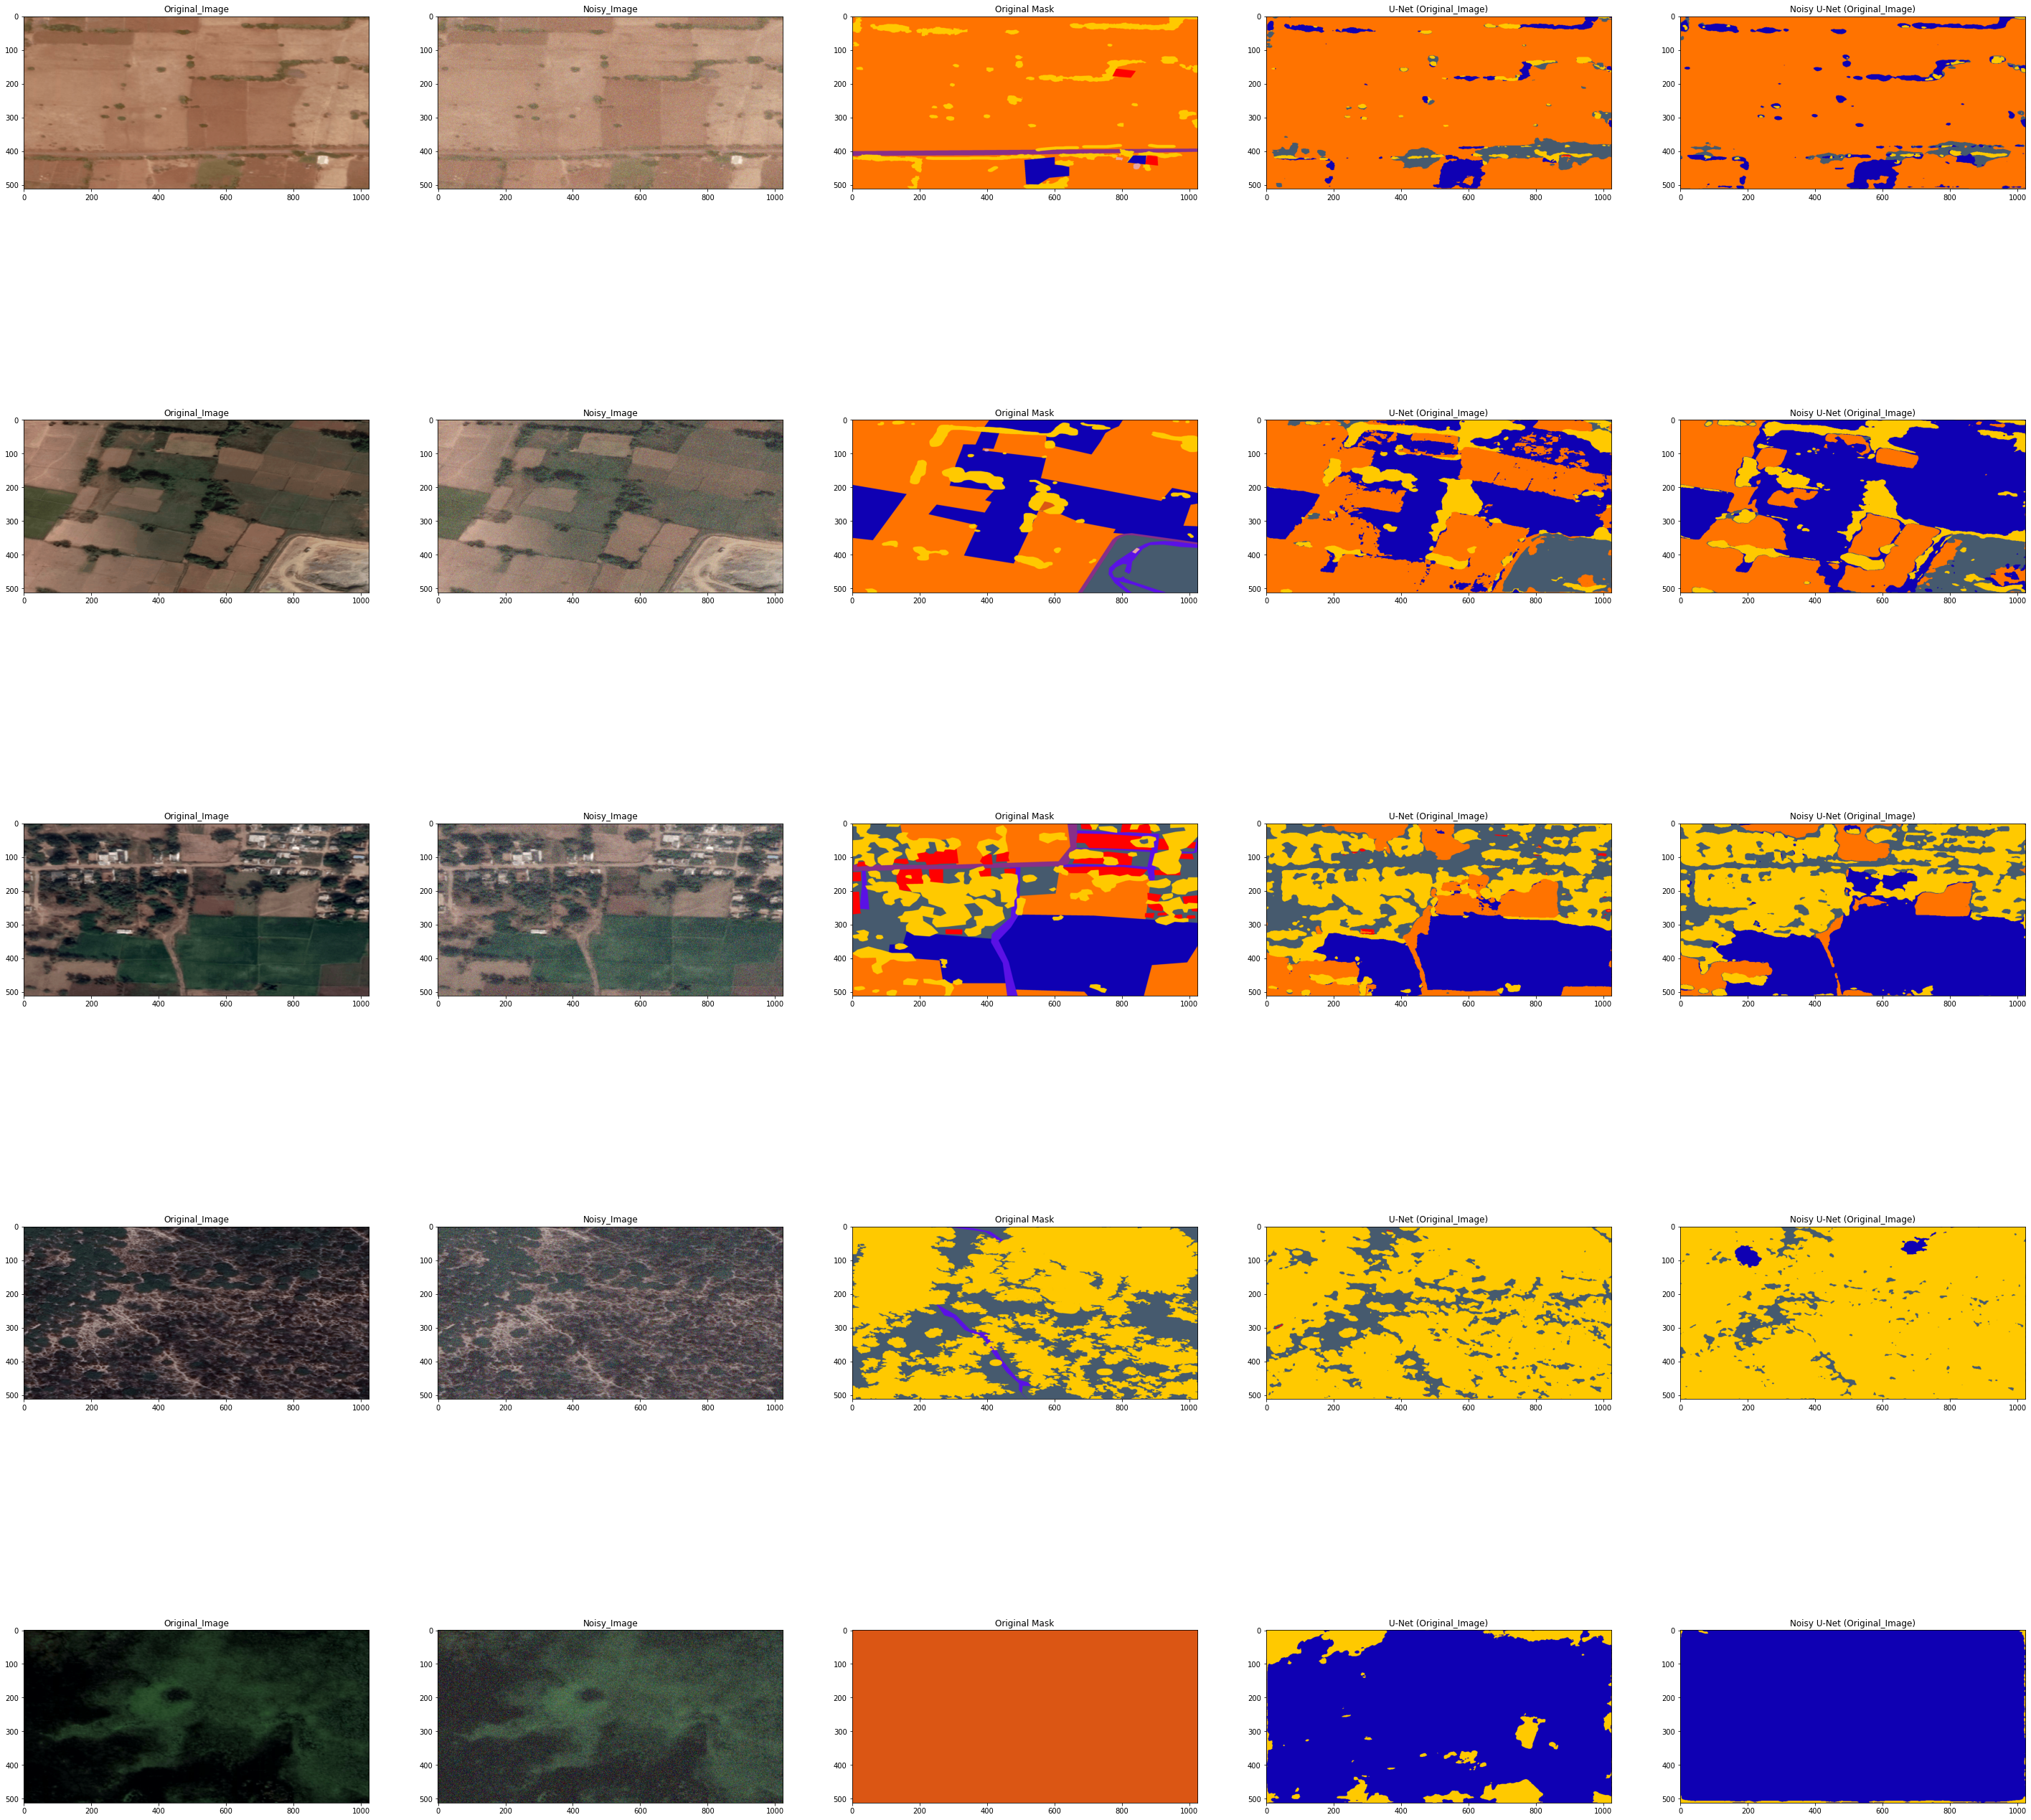

In [ ]:
count=0
fig = plt.figure(figsize=(50,50))
ax1 = fig.add_subplot(5,5,1)
for i in range(5):
    idx = np.random.randint(0, len(train))
    count+=1
    plt.subplot(5,5,count)
    plt.imshow(Image.open("/content/drive/MyDrive/train test split/train/satellite/" + train.iloc[idx,0].split(".json")[0] + ".png").resize((1024,512)))
    plt.title("Original_Image")

    count+=1
    plt.subplot(5,5,count)
    plt.imshow(Image.open("/content/drive/MyDrive/train test split/train/noisy/" + train.iloc[idx,0].split(".json")[0] + "_noisy.png").resize((1024,512)))
    plt.title("Noisy_Image")

    count+=1
    plt.subplot(5,5,count)
    plt.imshow(Image.open("/content/drive/MyDrive/train test split/train/masks/" + train.iloc[idx,0].split(".json")[0] + ".png").resize((1024,512)))
    plt.title("Original Mask")

    count+=1
    plt.subplot(5,5,count)
    plt.imshow(visualize_prediction("/content/drive/MyDrive/train test split/train/satellite/" + train.iloc[idx,0].split(".json")[0] + ".png"))
    plt.title("U-Net (Original_Image)")

    # count+=1
    # plt.subplot(5,5,count)
    # plt.imshow(visualize_prediction("/content/drive/MyDrive/train test split/train/noisy/" + train.iloc[idx,0].split(".json")[0] + "_noisy.png"))
    # plt.title("U-Net (Noisy_Image)")

    count+=1
    plt.subplot(5,5,count)
    plt.imshow(visualize_prediction_noisy("/content/drive/MyDrive/train test split/train/satellite/" + train.iloc[idx,0].split(".json")[0] + ".png"))
    plt.title("Noisy U-Net (Original_Image)")

    # count+=1
    # plt.subplot(5,5,count)
    # plt.imshow(visualize_prediction_noisy("/content/drive/MyDrive/train test split/train/noisy/" + train.iloc[idx,0].split(".json")[0] + "_noisy.png"))
    # plt.title("Noisy U-Net (Noisy_Image)")